In [1]:
!pip install datasets
!pip install jiwer

!pip install matplotlib
!pip install transformers

  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached pandas-2.2.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached fsspec-2024.9.0-py3-none-any.whl (179 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 51.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 15.2 MB/s eta 0:00:00
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached filelock-3.16.1-py3-none-any.whl (16 kB)
Using cached pandas-2.2.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)
Using cached tzdata-

In [15]:
print("test")


test


In [6]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from jiwer import wer, cer
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchaudio.transforms as T
from torch.nn.utils.rnn import pad_sequence

In [16]:
# 경로 설정
# 샘플 데이터 경로
audio_dir = "../sampledata/audio"
label_dir = "../sampledata/label"

#경로 설정
# audio_dir = "/content/drive/MyDrive/public/dataset/audio"
# label_dir = "/content/drive/MyDrive/public/dataset/label"

FileNotFoundError: [Errno 2] No such file or directory: 'https://drive.google.com/drive/folders/1CijuhVjLsuOkOulydjjizXPHQZF_D6su?usp=sharing/audio'

In [24]:
# 1. Dataset 클래스 정의
class AudioDataset(Dataset):
    def __init__(self, audio_dir, label_dir, processor, target_sample_rate=16000):
        self.audio_dir = audio_dir
        self.label_dir = label_dir
        self.processor = processor
        self.target_sample_rate = target_sample_rate
        self.audio_files = [f for f in os.listdir(audio_dir) if f.endswith(".wav")]

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_file = self.audio_files[idx]
        label_file = audio_file.replace(".wav", ".txt")

        # 오디오 로드
        audio_path = os.path.join(self.audio_dir, audio_file)
        waveform, sr = load_audio(audio_path, self.target_sample_rate)

        # 레이블 로드
        label_path = os.path.join(self.label_dir, label_file)
        with open(label_path, 'r', encoding='utf-8') as f:
            label = f.read().strip()

        # 전처리 (Whisper 모델에 맞게)
        input_features = self.processor(waveform.numpy(), sampling_rate=self.target_sample_rate, return_tensors="pt").input_features
        return input_features.squeeze(), label

In [26]:

# 오디오 파일 로드 및 리샘플링
def load_audio(file_path, target_sample_rate=16000):
    waveform, sample_rate = torchaudio.load(file_path)

    # 샘플링 레이트가 16kHz가 아닌 경우 리샘플링
    if sample_rate != target_sample_rate:
        resampler = T.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
        waveform = resampler(waveform)

    return waveform.squeeze(), target_sample_rate

# Custom Collate Function: 패딩을 추가하여 배치 내 입력 크기 통일
# def collate_fn(batch):
#     input_features = [item[0] for item in batch]  # 오디오 특징
#     labels = [item[1] for item in batch]  # 라벨 (텍스트)

#     # Whisper processor로 input_features를 패딩
#     input_features_padded = pad_sequence(input_features, batch_first=True)

#     # 라벨을 패딩
#     label_ids = processor.tokenizer(labels, return_tensors="pt", padding=True).input_ids

#     return input_features_padded, label_ids

# 2. 데이터셋 생성 및 95:5 비율로 학습/평가 데이터 분리
def create_dataloaders(audio_dir, label_dir, processor, batch_size=8, train_split=0.90):
    dataset = AudioDataset(audio_dir, label_dir, processor)
    train_size = int(len(dataset) * train_split)
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader

In [27]:
# 3. 모델 훈련 함수
def train(model, processor, train_loader, val_loader, num_epochs=5, device='cuda'):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    model.train()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Training loop
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader):
            inputs, labels = batch
            inputs = inputs.to(device)

            # 레이블을 텍스트에서 토큰으로 변환
            label_ids = processor.tokenizer(labels, return_tensors="pt", padding=True).input_ids.to(device)

            # 모델 예측
            outputs = model(input_features=inputs, labels=label_ids)
            loss = outputs.loss
            total_loss += loss.item()

            # 역전파 및 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Training loss: {total_loss / len(train_loader)}")

        # Evaluation loop
        evaluate(model, processor, val_loader, device)

In [28]:

# 4. 평가 함수
def evaluate(model, processor, val_loader, device='cuda'):
    model.eval()
    predictions = []
    actuals = []

    # 한국어로 강제 설정 (language code for Korean is "<|ko|>")
    forced_decoder_ids = processor.tokenizer.convert_tokens_to_ids(["<|ko|>"])

    with torch.no_grad():
        for batch in tqdm(val_loader):
            inputs, labels = batch
            inputs = inputs.to(device)

            # 한국어로 강제 설정 (language code for Korean is "<|ko|>")
            # 1은 모델의 BOS (beginning of sentence) 토큰에 해당
            predicted_ids = model.generate(inputs, forced_decoder_ids=[[1, forced_decoder_ids[0]]])
            transcriptions = processor.batch_decode(predicted_ids, skip_special_tokens=True)

            predictions.extend(transcriptions)
            actuals.extend(labels)

    # WER, CER 계산
    wer_score = wer(actuals, predictions)
    cer_score = cer(actuals, predictions)
    print(f"WER: {wer_score}, CER: {cer_score}")

    return predictions, actuals

# 5. 성능 평가 시각화 및 예측 결과 출력
def plot_results(predictions, actuals):
    wer_scores = [wer([a], [p]) for a, p in zip(actuals, predictions)]
    cer_scores = [cer([a], [p]) for a, p in zip(actuals, predictions)]

    plt.figure(figsize=(10, 5))

    # WER 시각화
    plt.subplot(1, 2, 1)
    plt.hist(wer_scores, bins=10, alpha=0.75, color='blue')
    plt.title('Word Error Rate (WER)')
    plt.xlabel('WER')
    plt.ylabel('Frequency')

    # CER 시각화
    plt.subplot(1, 2, 2)
    plt.hist(cer_scores, bins=10, alpha=0.75, color='green')
    plt.title('Character Error Rate (CER)')
    plt.xlabel('CER')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # 예측 결과 출력
    for i, (pred, act) in enumerate(zip(predictions, actuals)):
        print(f"예측 결과 {i + 1}:")
        print(f"  예측: {pred}")
        print(f"  실제: {act}")
        print("-" * 50)

# # 6. 전체 학습 및 평가 파이프라인 실행
# def run_pipeline(audio_dir, label_dir, batch_size=8, num_epochs=5):
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#     # Whisper 모델과 프로세서 준비
#     processor = WhisperProcessor.from_pretrained("openai/whisper-small")
#     model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to(device)

#     # 데이터 로더 생성
#     train_loader, val_loader = create_dataloaders(audio_dir, label_dir, processor, batch_size=batch_size)

#     # 모델 훈련
#     train(model, processor, train_loader, val_loader, num_epochs=num_epochs, device=device)
#     print("Training complete.")

#     # 모델 평가 및 결과 시각화
#     predictions, actuals = evaluate(model, processor, val_loader, device=device)
#     plot_results(predictions, actuals)

# # 실행
# run_pipeline(audio_dir, label_dir)

In [29]:
# 6. 전체 학습 및 평가 파이프라인 실행
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 디바이스 설정
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Whisper 모델과 프로세서 준비
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to(device)

batch_size=8
num_epochs=10
# 데이터 로더 생성
train_loader, val_loader = create_dataloaders(audio_dir, label_dir, processor, batch_size=batch_size)

# 모델 훈련
train(model, processor, train_loader, val_loader, num_epochs=num_epochs, device=device)
print("Training complete.")

# 모델 평가 및 결과 시각화
predictions, actuals = evaluate(model, processor, val_loader, device=device)
plot_results(predictions, actuals)







Epoch 1/10


  0%|          | 0/100 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../sampledata/label/ID-02-26-N-BJS-02-02-F-32-JJ2_043.txt'

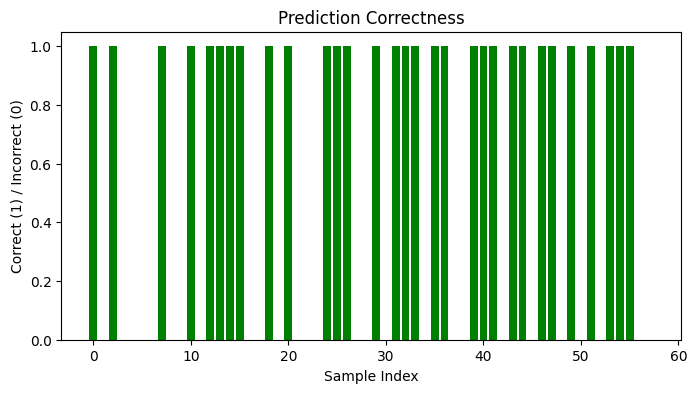

In [ ]:
   # (4) 일치/불일치 정확도 그래프
correct = [1 if p == a else 0 for p, a in zip(predictions, actuals)]
plt.figure(figsize=(8, 4))
plt.bar(range(len(correct)), correct, color=['green' if x == 1 else 'red' for x in correct])
plt.title("Prediction Correctness")
plt.xlabel("Sample Index")
plt.ylabel("Correct (1) / Incorrect (0)")
plt.show()

In [ ]:
wer_scores = [wer([a], [p]) for a, p in zip(actuals, predictions)]
cer_scores = [cer([a], [p]) for a, p in zip(actuals, predictions)]

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


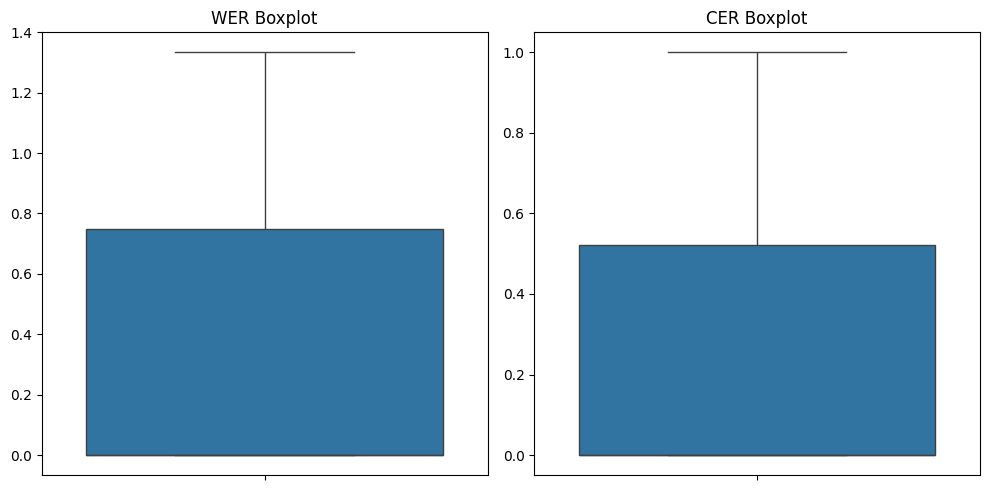

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# (2) WER, CER Boxplot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.boxplot(wer_scores)
plt.title('WER Boxplot')

plt.subplot(1, 2, 2)
sns.boxplot(cer_scores)
plt.title('CER Boxplot')

plt.tight_layout()
plt.show()

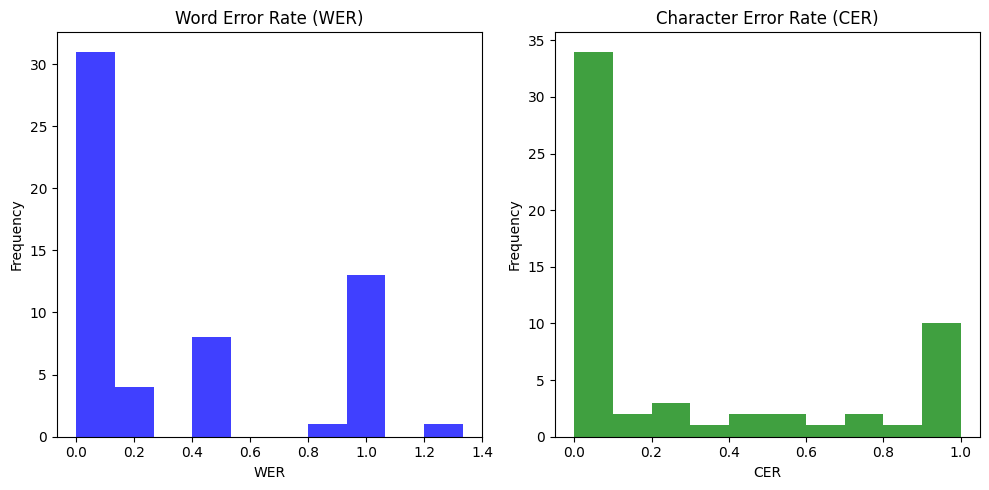

In [ ]:
    plt.figure(figsize=(10, 5))

    # WER 시각화
    plt.subplot(1, 2, 1)
    plt.hist(wer_scores, bins=10, alpha=0.75, color='blue')
    plt.title('Word Error Rate (WER)')
    plt.xlabel('WER')
    plt.ylabel('Frequency')

    # CER 시각화
    plt.subplot(1, 2, 2)
    plt.hist(cer_scores, bins=10, alpha=0.75, color='green')
    plt.title('Character Error Rate (CER)')
    plt.xlabel('CER')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()